%pip install torch torchvision
%pip install ipykernel
%pip install matplotlib

## Training 3 different models

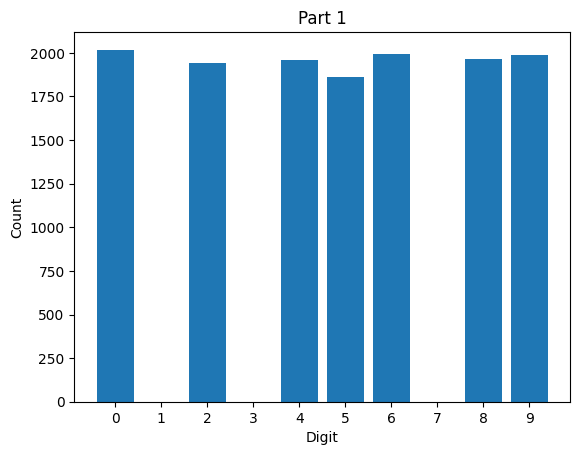

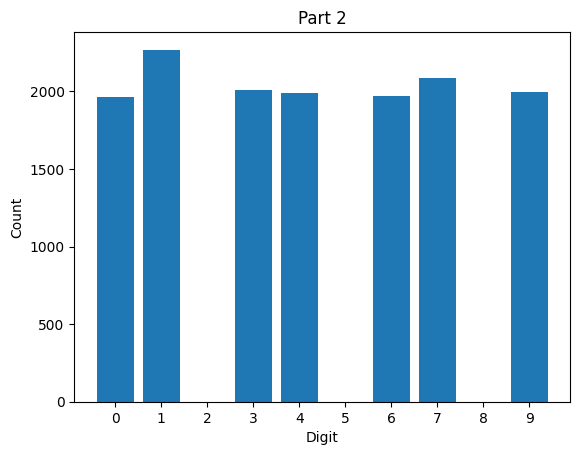

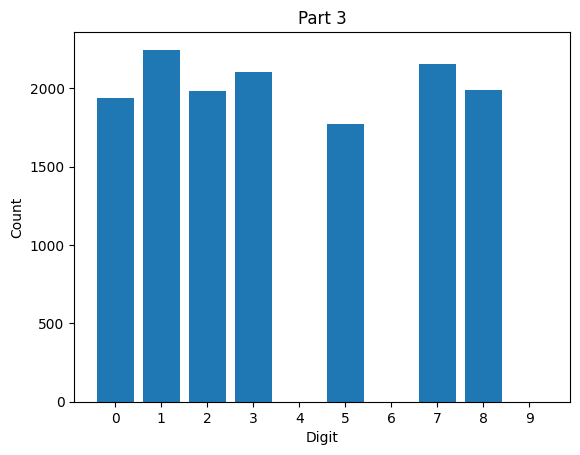

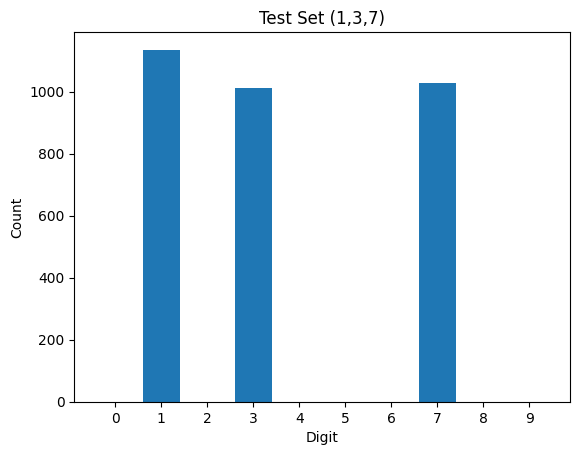

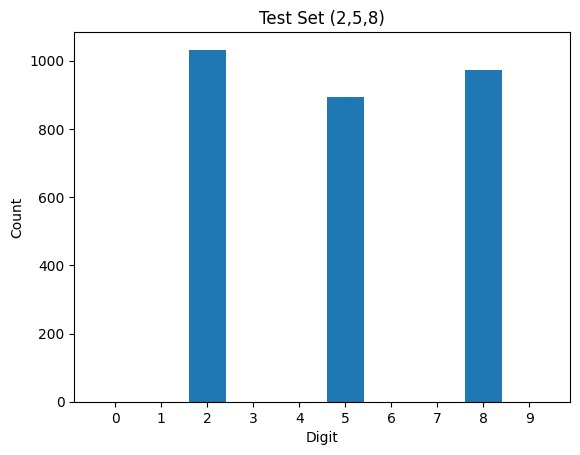

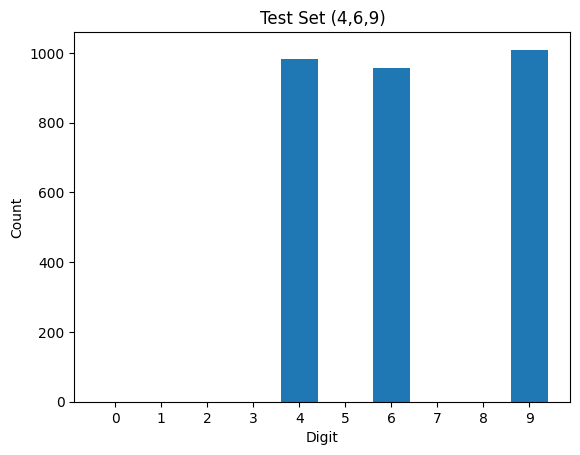

In [11]:
import torch
from torch.utils.data import random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter

# Load MNIST
transform = transforms.ToTensor()

trainset = datasets.MNIST(
    "../MNIST_data/",
    download=True,
    train=True,
    transform=transform
)

# Load test set
testset = datasets.MNIST(
    "../MNIST_data/",
    download=True,
    train=False,
    transform=transform
)

# Split into 3 parts
total_length = len(trainset)
split_size = total_length // 3

torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

# Function to exclude specific digits
def exclude_digits(dataset, excluded_digits):
    indices = [
        i for i in range(len(dataset))
        if dataset[i][1] not in excluded_digits
    ]
    return Subset(dataset, indices)

def include_digits(dataset, included_digits):
    indices = [
        i for i in range(len(dataset))
        if dataset[i][1] in included_digits
    ]
    return Subset(dataset, indices)

# Function to plot label distribution
def plot_distribution(dataset, title):
    from collections import Counter
    import matplotlib.pyplot as plt

    labels = [dataset[i][1] for i in range(len(dataset))]
    counter = Counter(labels)

    # Force digits 0–9 to appear
    digits = list(range(10))
    counts = [counter.get(d, 0) for d in digits]

    plt.figure()
    plt.bar(digits, counts)
    plt.xticks(digits)
    plt.title(title)
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

# Apply exclusions
part1 = exclude_digits(part1, [1, 3, 7])
part2 = exclude_digits(part2, [2, 5, 8])
part3 = exclude_digits(part3, [4, 6, 9])

train_sets = [part1, part2, part3]

testset_137 = include_digits(testset, [1, 3, 7]) 
testset_258 = include_digits(testset, [2, 5, 8]) 
testset_469 = include_digits(testset, [4, 6, 9])

# Plot
plot_distribution(part1, "Part 1")
plot_distribution(part2, "Part 2")
plot_distribution(part3, "Part 3")
plot_distribution(testset_137, "Test Set (1,3,7)")
plot_distribution(testset_258, "Test Set (2,5,8)")
plot_distribution(testset_469, "Test Set (4,6,9)")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

def train_model(model, dataset, epochs=5, batch_size=64, lr=0.001):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
        
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            loss.backward()
            optimizer.step()
        
            # accumulate properly
            total_loss += loss.item() * labels.size(0)
        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # compute true averages
        avg_loss = total_loss / total
        accuracy = 100 * correct / total
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {avg_loss:.4f} "
              f"Accuracy: {accuracy:.2f}%")

    return model

In [5]:
model1 = SimpleModel()
train_model(model1, part1)

model2 = SimpleModel()
train_model(model2, part2)

model3 = SimpleModel()
train_model(model3, part3)

Epoch [1/5] Loss: 0.5654 Accuracy: 84.36%
Epoch [2/5] Loss: 0.2475 Accuracy: 92.73%
Epoch [3/5] Loss: 0.1959 Accuracy: 94.19%
Epoch [4/5] Loss: 0.1638 Accuracy: 95.10%
Epoch [5/5] Loss: 0.1366 Accuracy: 96.05%
Epoch [1/5] Loss: 0.4567 Accuracy: 88.84%
Epoch [2/5] Loss: 0.1781 Accuracy: 94.88%
Epoch [3/5] Loss: 0.1452 Accuracy: 95.77%
Epoch [4/5] Loss: 0.1200 Accuracy: 96.63%
Epoch [5/5] Loss: 0.1031 Accuracy: 96.95%
Epoch [1/5] Loss: 0.5489 Accuracy: 84.94%
Epoch [2/5] Loss: 0.2574 Accuracy: 92.15%
Epoch [3/5] Loss: 0.1977 Accuracy: 94.05%
Epoch [4/5] Loss: 0.1671 Accuracy: 94.92%
Epoch [5/5] Loss: 0.1394 Accuracy: 95.83%


SimpleModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Flower framework

%pip install flwr

In [10]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

When a client receives model parameters from the server, it is supposed to update the local model with those new parameters. When the training is done, the local parameters of the newly trained model now needs to be sent back to the server.

In [12]:
# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

To connect your existing training pipeline to this setter and getter, you need to add a flower client. A client will facilitate training, evaluation and updating local model as well as sending over the trained model to server.

In [18]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

# Client function
# Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate.
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

In [19]:
client = ClientApp(client_fn)